In [1]:
import os, sys
import numpy as np
from astropy.io import fits
from astropy.time import Time
from astropy import units as u
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

In [2]:
%load_ext autoreload
%autoreload 2
sys.path.append("/Users/arcticfox/Documents/GitHub/wobble")
import wobble

//anaconda3/lib/python3.7/site-packages/dask/dataframe/utils.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
files = os.listdir('.')
tars = np.sort([i for i in files if i.endswith('.tar')])
files = np.sort([i for i in files if i.endswith('ccf_G2_A.fits')])

In [ ]:
my_rvs = np.load('my_rvs.npy', allow_pickle=True)
my_times = Time(my_rvs[0], format='mjd').jd
self_rvs = my_rvs[1] * u.m / u.s

## GRACES data

In [ ]:
import alphashape
from numpy.polynomial import Polynomial

In [ ]:
def fit_alpha(w, f, deg=11, alpha=1.0, mask=None):
    
    if mask is not None:
        w_new = w[mask] + 0.0
        f_new = f[mask] + 0.0
    else:
        w_new = w + 0.0
        f_new = f + 0.0
        
    points = [(w_new[i], f_new[i]) for i in range(len(w_new))]
    
    alpha_shape = alphashape.alphashape(points, alpha)

    try:
        indices = [np.argmin(alpha_shape.exterior.xy[0]), 
                           np.argmax(alpha_shape.exterior.xy[0])]
        if indices[0] > indices[1]:
            indices = [indices[0], len(alpha_shape.exterior.xy[0])]
        bound_wave = alpha_shape.exterior.xy[0][indices[0]:indices[1]]
        bound_spec = alpha_shape.exterior.xy[1][indices[0]:indices[1]]
    except:
        indices = [np.argmin(alpha_shape.boundary.geoms[0].xy[0]),
                   np.argmax(alpha_shape.boundary.geoms[0].xy[0])]
        if indices[0] > indices[1]:
            indices = [indices[0], len(alpha_shape.boundary.geoms[0].xy[0])]

        bound_wave = alpha_shape.boundary.geoms[0].xy[0][indices[0]:indices[1]]
        bound_spec = alpha_shape.boundary.geoms[0].xy[1][indices[0]:indices[1]]

    fit = Polynomial.fit(bound_wave, bound_spec, deg=deg)
    y_smooth = fit(w)

    return alpha_shape, y_smooth, bound_wave, bound_spec

In [4]:
name_ext = 'all_new'
graces_dir = '/Users/arcticfox/Downloads/gemini_data_new/'
graces_files = np.sort([os.path.join(graces_dir, i) for i in os.listdir(graces_dir) if 
                       i.endswith('m.fits')])

In [5]:
lengths_per = []
hdu = fits.open(graces_files[0])
uo = len(np.unique(hdu[0].data[0]))
for uo in np.unique(hdu[0].data[0]):
    lengths_per.append(len(hdu[0].data[4][hdu[0].data[0]==uo]))
hdu.close()

In [6]:
np.nanmin(lengths_per)

4055

In [7]:
waves = np.zeros((len(graces_files), int(np.nanmin(lengths_per)*uo)))
ordr  = np.zeros((len(graces_files), int(np.nanmin(lengths_per)*uo)))
spec  = np.zeros((len(graces_files), int(np.nanmin(lengths_per)*uo)))
errs  = np.zeros((len(graces_files), int(np.nanmin(lengths_per)*uo)))

for i, fn in tqdm_notebook(enumerate(graces_files), total=len(graces_files)):
    hdu = fits.open(fn)
    for j, o in enumerate(np.unique(hdu[0].data[0])):
        q = hdu[0].data[0] == o
        
        w = np.copy(hdu[0].data[4][q])
        s = np.copy(hdu[0].data[10][q])
        e = np.copy(hdu[0].data[11][q])
        
        if len(w) != np.nanmin(lengths_per):
            diff = int((np.abs(len(w)-np.nanmin(lengths_per)))/2)

            if len(w) % 2 == 0:
                w = w[1+diff:len(w)-diff]
                s = s[1+diff:len(s)-diff]
                e = e[1+diff:len(e)-diff]
            else:
                w = w[diff:len(w)-diff]
                s = s[diff:len(s)-diff]
                e = e[diff:len(e)-diff]
                
        if np.nanmin(lengths_per) != len(w):
            print(np.nanmin(lengths_per), len(w))
        #u = (np.nanmax(w) - np.nanmin(w)) / (10 * np.nanmax(s))
        #s *= u

        #std1 = 3.0
        #mask = np.where( (s < std1*np.std(s) + np.nanmedian(s)) &
        #                 (s > -std1*np.nanstd(s) + np.nanmedian(s)))[0]
        #alpha_shape, y_smooth, bw, bs = fit_alpha(w, s, alpha=2.5, mask=mask)
        
        #plt.plot(w, s, 'k')
        #plt.plot(w, s/y_smooth, 'darkorange')
        #plt.show()
        
        reg = [int(j*np.nanmin(lengths_per)), int((j+1)*np.nanmin(lengths_per))]

        waves[i][reg[0]:reg[1]] = w
        spec[i][reg[0]:reg[1]] = s + 1#/ y_smooth
        errs[i][reg[0]:reg[1]] = e
        ordr[i][reg[0]:reg[1]] = o
        #33333333333333333333333333333FV!~Q

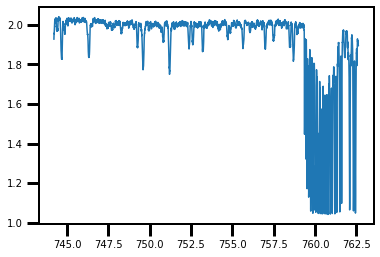

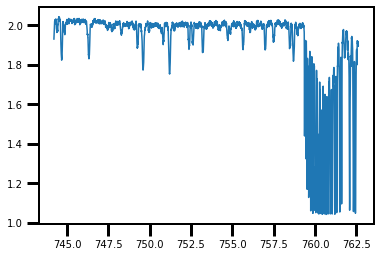

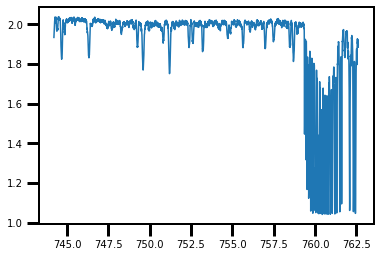

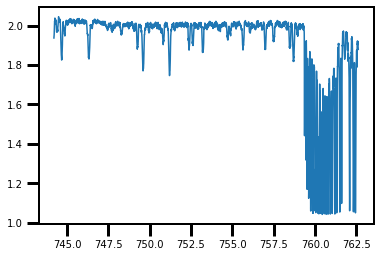

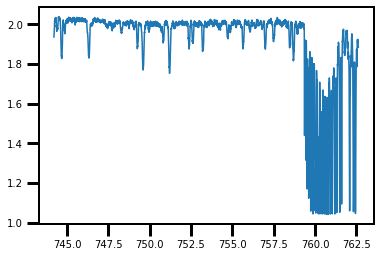

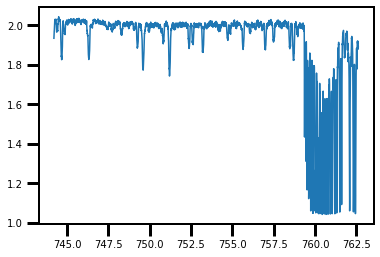

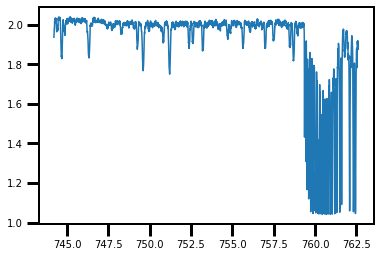

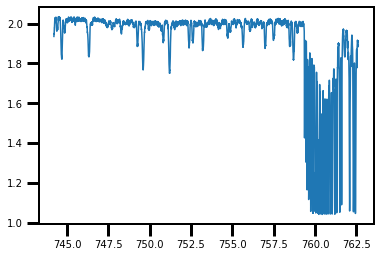

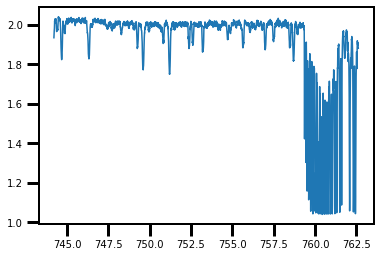

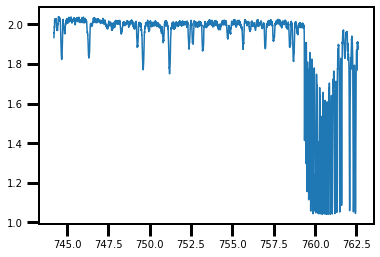

In [8]:
for i in range(10):
    plt.plot(waves[i][ordr[i]==30], spec[i][ordr[i]==30])
    plt.show()

In [9]:
ra, dec = 61.331629, 20.1571

In [10]:
graces = wobble.Data()

In [11]:
waves[i].shape

(227080,)

In [12]:
for i in tqdm_notebook(range(len(graces_files))):
    sp = wobble.Spectrum()
    sp.from_GRACES(graces_files[i], process=True, 
                   waves=waves[i],
                   spec=spec[i],
                   ordrs=ordr[i],
                   errs=errs[i],
                   ra=ra, dec=dec)
    graces.append(sp)

In [ ]:
for i in range(4):
    print(graces.xs[i].shape)

In [ ]:
graces.write('graces_wobble_new_all_ben.hdf5'.format(name_ext))

In [24]:
data = wobble.Data(filename='graces_wobble_new_all_ben.hdf5',
                   orders=np.arange(10,23,1,dtype=int))
R = np.copy(data.R)

In [25]:
data.drop_bad_orders(min_snr=3)
data.drop_bad_epochs(min_snr=3)

In [26]:
import h5py

In [27]:
path1 = '/Users/arcticfox/Documents/atmospheres/v1298tau/'

In [28]:
telluric_wave_model = np.array([])
telluric_spec_model = np.array([])

for fn in ['telluric_model_b.hdf', 'telluric_model_r.hdf']:
    f = h5py.File(os.path.join(path1, fn), 'r')
    
    for i, key in enumerate(f['wavelength_solution']['fiber_2'].keys()):
        telluric_wave = f['wavelength_solution']['fiber_2'][key][()]
        telluric_spec = f['telluric_model']['fiber_2'][key][()]

        telluric_wave_model = np.append(telluric_wave_model, telluric_wave)
        telluric_spec_model = np.append(telluric_spec_model, telluric_spec)

In [29]:
data.orders, np.shape(data.xs)

(array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]), (13, 33, 4055))

In [30]:
twm, tsm = zip(*sorted(zip(telluric_wave_model, telluric_spec_model)))
twm, tsm = np.array(twm), np.array(tsm) 

tom = np.zeros(len(twm), dtype=int)
for uo in range(len(data.orders)):
    start = np.exp(data.xs[uo][0][0])
    end   = np.exp(data.xs[uo][0][-1])
    inds  = np.where((twm >= start) & (twm <= end))[0]
    print(uo, len(inds), start, end)
    tom[inds] = data.orders[uo]

0 9661 677.0138549804685 693.6793212890628
1 17331 656.830139160156 673.0578613281249
2 11896 638.4820556640626 654.1743164062501
3 9951 620.7843017578126 636.0366821289062
4 9515 604.0272216796875 618.8668823242188
5 9432 588.1987915039061 602.6388549804689
6 10493 573.1473999023439 587.2151489257812
7 10501 558.9083251953127 572.6114501953124
8 10367 545.25146484375 558.6277465820312
9 10832 532.2554931640624 545.3188476562501
10 11398 519.9050903320314 532.6629638671876
11 11369 508.08273315429705 520.5543823242186
12 8223 496.7587890625 508.9624328613281


In [75]:
xs_r = [np.log(np.array(twm[tom==r]))-0.00028 for r in data.orders]
ys_r = [np.log(np.array(tsm[tom==r])) for r in data.orders]

In [76]:
np.shape(xs_r)

(13,)

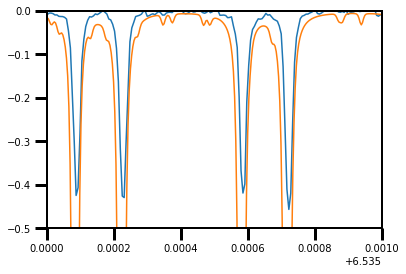

In [77]:
for i in range(1):
    plt.plot(data.xs[i][0], data.ys[i][0])
    plt.plot(xs_r[i], ys_r[i])
    plt.ylim(-0.5,0)
    plt.xlim(6.535,6.536)
    plt.show()

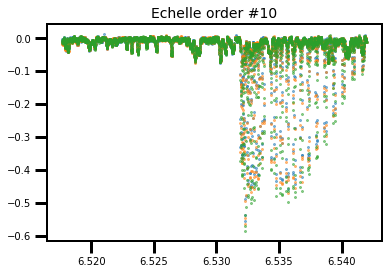

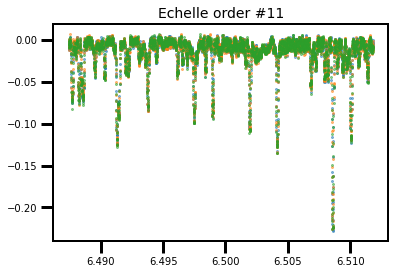

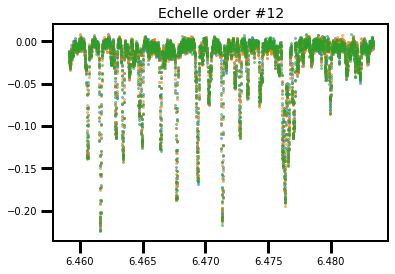

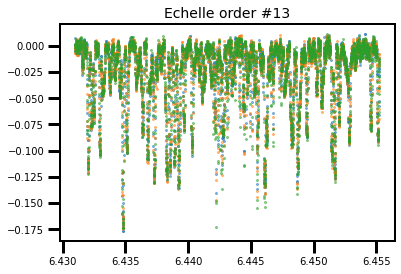

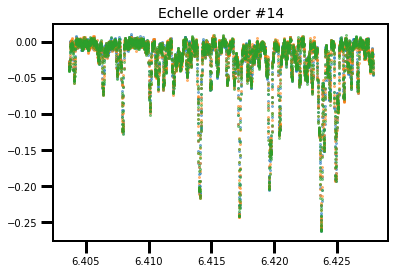

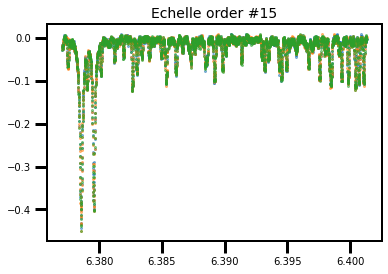

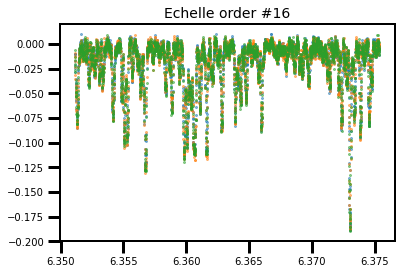

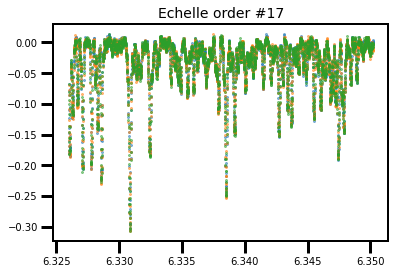

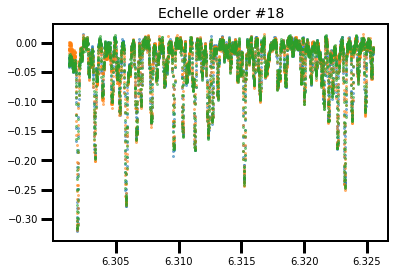

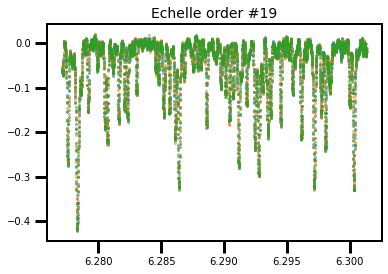

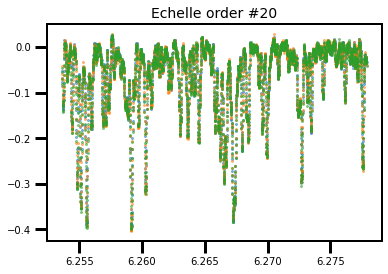

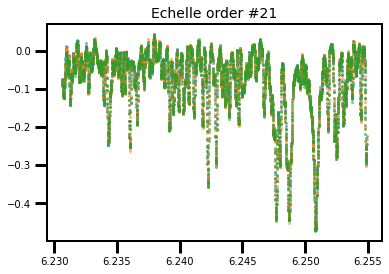

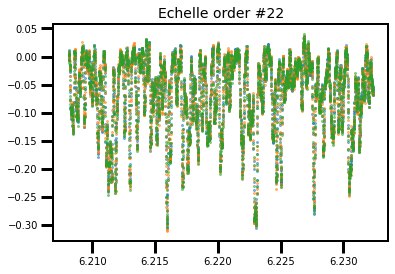

In [34]:
for r in range(len(data.ivars)):
    good = data.ivars[r] > 0

    for e in [0,7,17]:
        plt.plot(data.xs[r][e][good[e]], data.ys[r][e][good[e]], 'o',
                 ms=2, alpha=0.5)
    plt.title('Echelle order #{0}'.format(data.orders[r]), fontsize=14)
    plt.show()

In [35]:
results = wobble.Results(data=data)

Only run for the reasonable orders

In [78]:
for r in range(len(data.orders)):
        print('starting order {0} of {1}'.format(r+1, len(data.orders)))
        model = wobble.Model(data, results, r)
        model.add_star('star')
        model.add_telluric('tellurics', 
                           template_xs=xs_r[r], 
                           template_ys=ys_r[r], 
                           template_fixed=False)
        wobble.optimize_order(model)

starting order 1 of 13


  0%|          | 0/100 [00:00<?, ?it/s]

optimize: iterating through 100 optimization steps...


  0%|          | 0/33 [00:00<?, ?it/s]

optimize: calculating uncertainties on star rvs...


100%|██████████| 33/33 [00:01<00:00, 24.33it/s]


starting order 2 of 13


  0%|          | 0/100 [00:00<?, ?it/s]

optimize: iterating through 100 optimization steps...


  0%|          | 0/33 [00:00<?, ?it/s]

optimize: calculating uncertainties on star rvs...


100%|██████████| 33/33 [00:01<00:00, 22.41it/s]


starting order 3 of 13


  0%|          | 0/100 [00:00<?, ?it/s]

optimize: iterating through 100 optimization steps...


  0%|          | 0/33 [00:00<?, ?it/s]

optimize: calculating uncertainties on star rvs...


100%|██████████| 33/33 [00:01<00:00, 21.87it/s]


starting order 4 of 13


  0%|          | 0/100 [00:00<?, ?it/s]

optimize: iterating through 100 optimization steps...


  0%|          | 0/33 [00:00<?, ?it/s]

optimize: calculating uncertainties on star rvs...


100%|██████████| 33/33 [00:01<00:00, 21.42it/s]


starting order 5 of 13


  0%|          | 0/100 [00:00<?, ?it/s]

optimize: iterating through 100 optimization steps...


  0%|          | 0/33 [00:00<?, ?it/s]

optimize: calculating uncertainties on star rvs...


100%|██████████| 33/33 [00:01<00:00, 23.82it/s]


starting order 6 of 13


  0%|          | 0/100 [00:00<?, ?it/s]

optimize: iterating through 100 optimization steps...


  0%|          | 0/33 [00:00<?, ?it/s]

optimize: calculating uncertainties on star rvs...


100%|██████████| 33/33 [00:01<00:00, 25.69it/s]


starting order 7 of 13


  0%|          | 0/100 [00:00<?, ?it/s]

optimize: iterating through 100 optimization steps...


  0%|          | 0/33 [00:00<?, ?it/s]

optimize: calculating uncertainties on star rvs...


100%|██████████| 33/33 [00:01<00:00, 19.28it/s]


starting order 8 of 13


  0%|          | 0/100 [00:00<?, ?it/s]

optimize: iterating through 100 optimization steps...


  0%|          | 0/33 [00:00<?, ?it/s]

optimize: calculating uncertainties on star rvs...


100%|██████████| 33/33 [00:01<00:00, 18.79it/s]


starting order 9 of 13


  0%|          | 0/100 [00:00<?, ?it/s]

optimize: iterating through 100 optimization steps...


  0%|          | 0/33 [00:00<?, ?it/s]

optimize: calculating uncertainties on star rvs...


100%|██████████| 33/33 [00:01<00:00, 19.56it/s]


starting order 10 of 13


  0%|          | 0/100 [00:00<?, ?it/s]

optimize: iterating through 100 optimization steps...


  0%|          | 0/33 [00:00<?, ?it/s]

optimize: calculating uncertainties on star rvs...


100%|██████████| 33/33 [00:01<00:00, 21.20it/s]


starting order 11 of 13


  0%|          | 0/100 [00:00<?, ?it/s]

optimize: iterating through 100 optimization steps...


  0%|          | 0/33 [00:00<?, ?it/s]

optimize: calculating uncertainties on star rvs...


100%|██████████| 33/33 [00:01<00:00, 21.13it/s]


starting order 12 of 13


  0%|          | 0/100 [00:00<?, ?it/s]

optimize: iterating through 100 optimization steps...


  0%|          | 0/33 [00:00<?, ?it/s]

optimize: calculating uncertainties on star rvs...


100%|██████████| 33/33 [00:01<00:00, 20.79it/s]


starting order 13 of 13


  0%|          | 0/100 [00:00<?, ?it/s]

optimize: iterating through 100 optimization steps...


  0%|          | 0/33 [00:00<?, ?it/s]

optimize: calculating uncertainties on star rvs...


100%|██████████| 33/33 [00:01<00:00, 20.51it/s]


- See if I can grab Megan B tomorrow and talk through everything to make sure she sanity checks everything

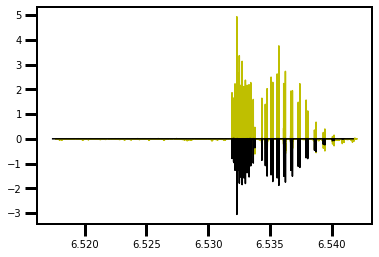

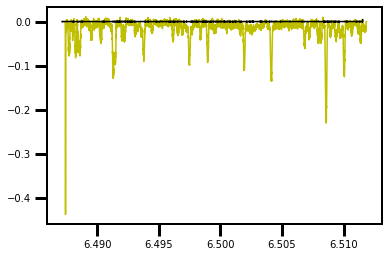

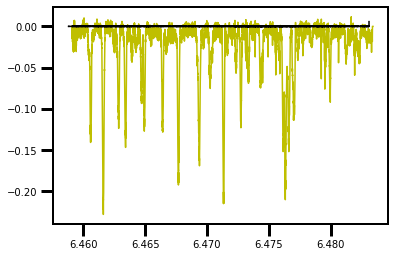

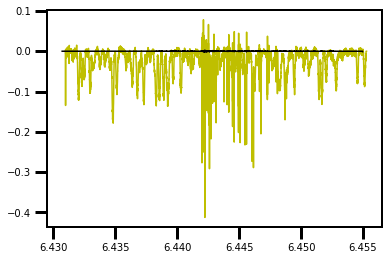

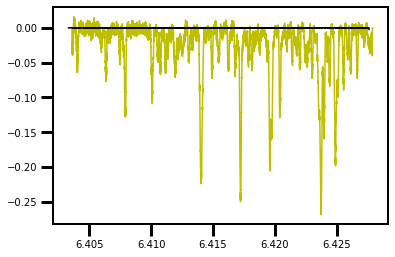

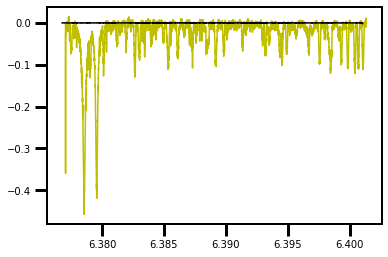

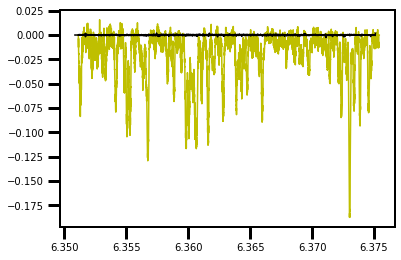

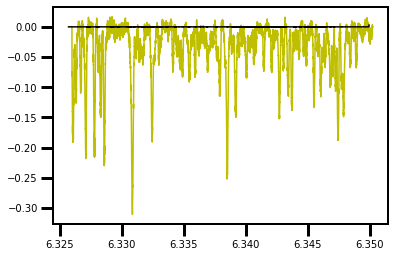

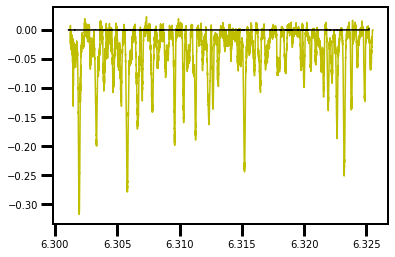

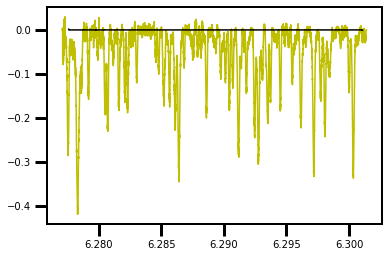

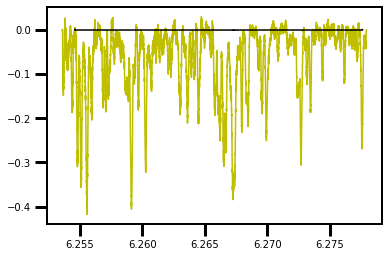

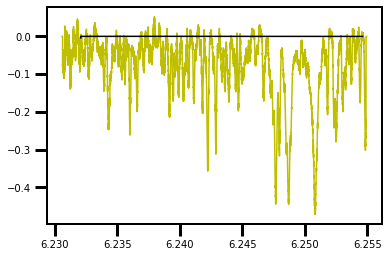

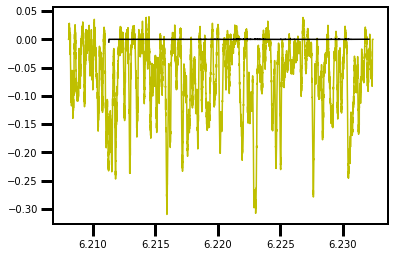

In [79]:
for i in range(len(results.star_template_xs)):
    plt.plot(results.star_template_xs[i], results.star_template_ys[i], 'y')
    plt.plot(results.tellurics_template_xs[i], results.tellurics_template_ys[i], 'k')
    plt.show()

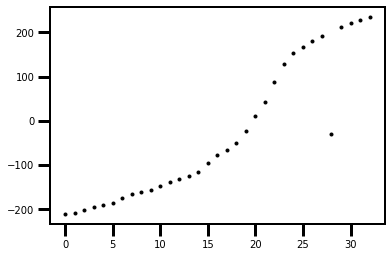

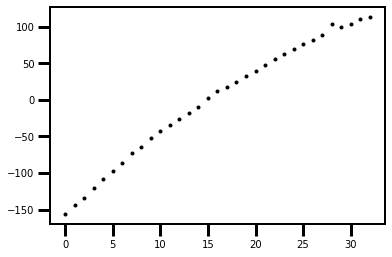

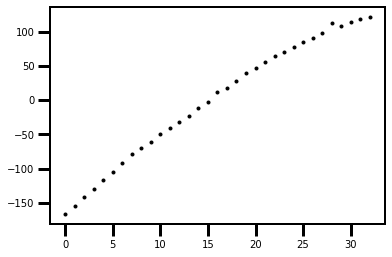

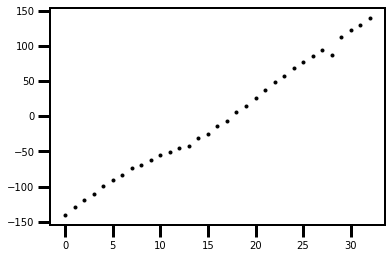

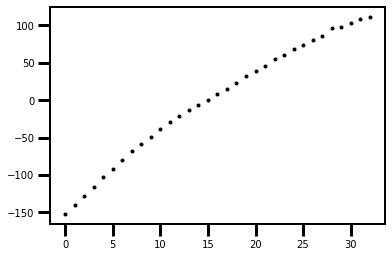

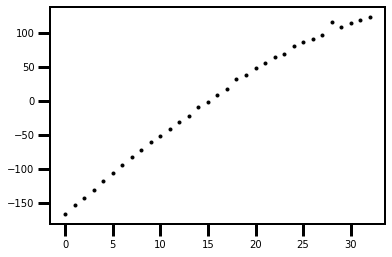

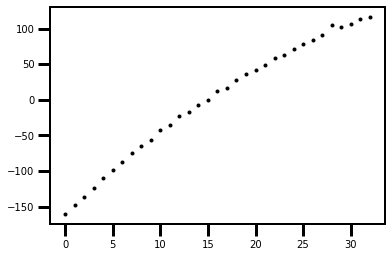

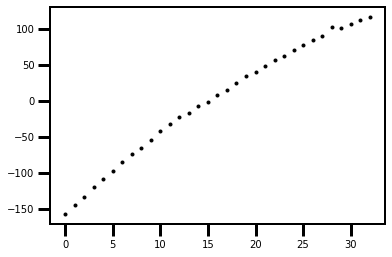

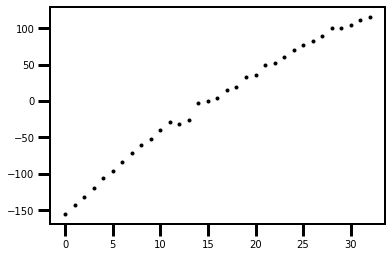

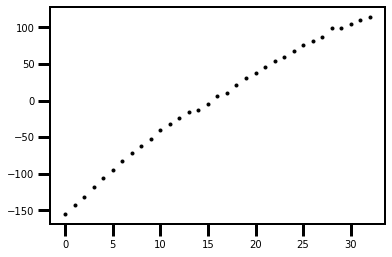

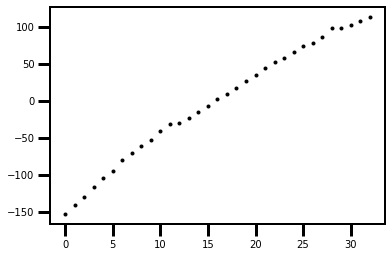

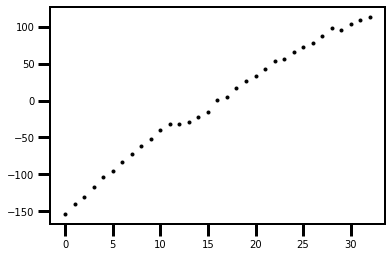

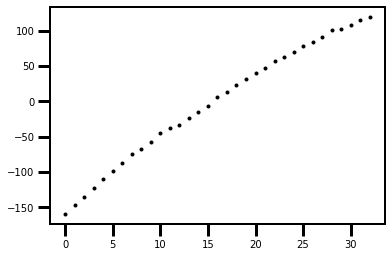

In [80]:
for i in range(len(data.orders)):
    #plt.plot(results.tellurics_rvs[i], 'w.')
    plt.plot(results.star_rvs[i], 'k.')
    plt.show()

In [81]:
results.combine_orders('star')

2
Desired error not necessarily achieved due to precision loss.


In [82]:
results.apply_drifts('star')
results.apply_bervs('star')

Text(0, 0.5, 'RV (m s$^{-1}$)')

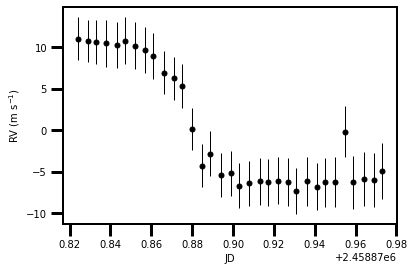

In [83]:
plt.errorbar(data.dates, results.star_time_rvs - np.mean(results.star_time_rvs), 
                     results.star_time_sigmas, c='k',
                    fmt='o', ms=5, elinewidth=1)
plt.xlabel('JD')
plt.ylabel(r'RV (m s$^{-1}$)')
#plt.savefig('/Users/arcticfox/Desktop/graces_wobble_{0}_26orders.png'.format(name_ext), 
#             dpi=250, rasterize=True)


In [50]:
#results.write('graces_wobble_old_all_results.hdf5')

In [68]:
#from IPython.display import Image
for r in range(len(data.orders)):
    results.plot_spectrum(r=r,
                          n=15,
                          data=data,
                          filename='/Users/arcticfox/Desktop/test{0}.png'.format(r))
    #Image('/Users/arcticfox/Desktop/test.png')